In [1]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import copy
import numpy as np
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from sklearn.manifold import TSNE

## Conditional Variational AutoEncoder (CVAE)

In [2]:
batch_size = 256
latent_dim = 8
epochs = 1000
lr = 1e-4
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_classes = 10

In [3]:
transform = transforms.ToTensor();
train_loader = DataLoader(
    datasets.MNIST(root="./data", train=True, download=True, transform=transform),
    batch_size=batch_size, shuffle=True
)

### CVAE Model
**layers:**
1. Fully Connected: concat of input images and their labels -> first layer neurons
2. 2 x Fully Connected: first layer nerons -> latent layer neurons (One for mean and one for log of variance)
3. Fullu Connected: concat of latent and labels -> third layer neurons
4. Fully Connected: third layer neurons -> input dimension (a new image)

In [4]:
class CVAE(nn.Module):
    def __init__(self, input_dim=784, label_dim=10, latent_dim=8):
        super().__init__()
        
        self.fc1 = nn.Linear(input_dim + label_dim, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc_mu = nn.Linear(256, latent_dim)
        self.fc_logvar = nn.Linear(256, latent_dim)
        self.fc3 = nn.Linear(latent_dim + label_dim, 256)
        self.fc4 = nn.Linear(256, 512)
        self.fc5 = nn.Linear(512, input_dim)

    def encode(self, x, y):
        h = torch.cat([x, y], dim=1)
        h = F.relu(self.fc1(h))
        h = F.relu(self.fc2(h))
        return self.fc_mu(h), self.fc_logvar(h)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z, y):
        h = torch.cat([z, y], dim=1)
        h = F.relu(self.fc3(h))
        h = F.relu(self.fc4(h))
        return torch.sigmoid(self.fc5(h))

    def forward(self, x, y):
        mu, logvar = self.encode(x, y)
        z = self.reparameterize(mu, logvar)
        recon_x = self.decode(z, y)
        return recon_x, mu, logvar

In [5]:
def loss_function(recon_x, x, mu, logvar):
    BCE = F.binary_cross_entropy(recon_x, x, reduction="sum")
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD

### Training

In [6]:
model = CVAE(latent_dim=latent_dim, label_dim=num_classes).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

In [7]:
save_dir = "checkpoints"
os.makedirs(save_dir, exist_ok=True)

best_loss = float('inf')

for epoch in range(1, epochs + 1):
    model.train()
    train_loss = 0

    for x, labels in train_loader:
        x = x.view(-1, 784).to(device)
        y = F.one_hot(labels, num_classes).float().to(device)

        optimizer.zero_grad()
        recon_x, mu, logvar = model(x, y)
        loss = loss_function(recon_x, x, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()

    avg_loss = train_loss / len(train_loader.dataset)
    if epoch % 10 == 0:
        print(f"Epoch {epoch}, Loss: {avg_loss:.4f}")

    if epoch % 10 == 0 or avg_loss < best_loss:
        ckpt_path = os.path.join(save_dir, f"epoch_{epoch:03d}.pt")
        torch.save(
            {
                "epoch": epoch,
                "model_state_dict": model.state_dict(),
                "optimizer_state_dict": optimizer.state_dict(),
                "loss": avg_loss,
            },
            ckpt_path,
        )

        if avg_loss < best_loss:
            best_loss = avg_loss
            best_path = os.path.join(save_dir, "best_model.pt")
            torch.save(
                {
                    "epoch": epoch,
                    "model_state_dict": model.state_dict(),
                    "optimizer_state_dict": optimizer.state_dict(),
                    "loss": avg_loss,
                },
                best_path,
            )
            
original_model = copy.deepcopy(model)

Epoch 10, Loss: 129.3822
Epoch 20, Loss: 116.8307
Epoch 30, Loss: 111.6438
Epoch 40, Loss: 108.6807
Epoch 50, Loss: 106.6493
Epoch 60, Loss: 105.1693
Epoch 70, Loss: 103.9431
Epoch 80, Loss: 102.9618
Epoch 90, Loss: 102.0959
Epoch 100, Loss: 101.3450
Epoch 110, Loss: 100.7118
Epoch 120, Loss: 100.1323
Epoch 130, Loss: 99.6358
Epoch 140, Loss: 99.2144
Epoch 150, Loss: 98.7802
Epoch 160, Loss: 98.3847
Epoch 170, Loss: 98.0433
Epoch 180, Loss: 97.7408
Epoch 190, Loss: 97.4243
Epoch 200, Loss: 97.1803
Epoch 210, Loss: 96.9071
Epoch 220, Loss: 96.6893
Epoch 230, Loss: 96.4657
Epoch 240, Loss: 96.2473
Epoch 250, Loss: 96.0607
Epoch 260, Loss: 95.9063
Epoch 270, Loss: 95.7311
Epoch 280, Loss: 95.5452
Epoch 290, Loss: 95.4076
Epoch 300, Loss: 95.2069
Epoch 310, Loss: 95.1092
Epoch 320, Loss: 94.9909
Epoch 330, Loss: 94.8382
Epoch 340, Loss: 94.7207
Epoch 350, Loss: 94.6061
Epoch 360, Loss: 94.4700
Epoch 370, Loss: 94.3684
Epoch 380, Loss: 94.2671
Epoch 390, Loss: 94.1545
Epoch 400, Loss: 94.06

In [7]:
ckpt = torch.load("checkpoints/best_model.pt", map_location=device)
model.load_state_dict(ckpt["model_state_dict"])
optimizer.load_state_dict(ckpt["optimizer_state_dict"])
start_epoch = ckpt["epoch"] + 1
print(f"✅ Loaded checkpoint from epoch {ckpt['epoch']} with loss {ckpt['loss']:.4f}")
original_model = copy.deepcopy(model)

✅ Loaded checkpoint from epoch 1000 with loss 91.1003


/tmp/ipykernel_6576/2398295826.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load("checkpoints/best_model.pt", map_location=device)


### Visualization

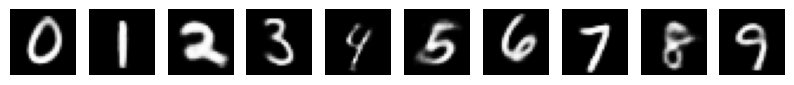

In [8]:
model.eval()
with torch.no_grad():
    z = torch.randn(num_classes, latent_dim).to(device)
    labels = torch.arange(num_classes).to(device)
    y = F.one_hot(labels, num_classes).float()
    # y = F.one_hot(torch.full((10,), 4, device=labels.device), num_classes).float()
    samples = model.decode(z, y.to(device)).cpu().view(-1, 1, 28, 28)

    fig, axes = plt.subplots(1, num_classes, figsize=(10, 2))
    for i, ax in enumerate(axes):
        ax.imshow(samples[i, 0], cmap="gray")
        ax.axis("off")
    plt.show()

### Latent Space Exploration

In [10]:
model.eval()
all_mu_mix = []
all_labels = []

with torch.no_grad():
    for x, labels in train_loader:
        x_flat = x.view(-1, 784).to(device)
        batch_size_curr = x_flat.size(0)
        
        mu_sum = torch.zeros((batch_size_curr, latent_dim), device=device)
        for y_label in range(num_classes):
            y_onehot = F.one_hot(torch.full((batch_size_curr,), y_label, dtype=torch.long, device=device),
                                 num_classes).float()
            mu_y, logvar_y = model.encode(x_flat, y_onehot)
            mu_sum += mu_y

        mu_mix = (mu_sum / float(num_classes)).cpu().numpy()
        all_mu_mix.append(mu_mix)
        all_labels.append(labels.numpy())

all_mu_mix = np.concatenate(all_mu_mix, axis=0)
all_labels = np.concatenate(all_labels, axis=0)

# t-SNE
print("Running t-SNE on uniform-marginalized mus ...")
tsne = TSNE(n_components=2, perplexity=30, learning_rate=200, random_state=42)
z_2d = tsne.fit_transform(all_mu_mix)

np.save("all_mu_mix.npy", all_mu_mix)
np.save("all_labels.npy", all_labels)
np.save("z_2d.npy", z_2d)

Running t-SNE on uniform-marginalized mus ...


In [9]:
all_mu_mix = np.load("all_mu_mix.npy")
all_labels = np.load("all_labels.npy")
z_2d = np.load("z_2d.npy")

#### Digits Distribution

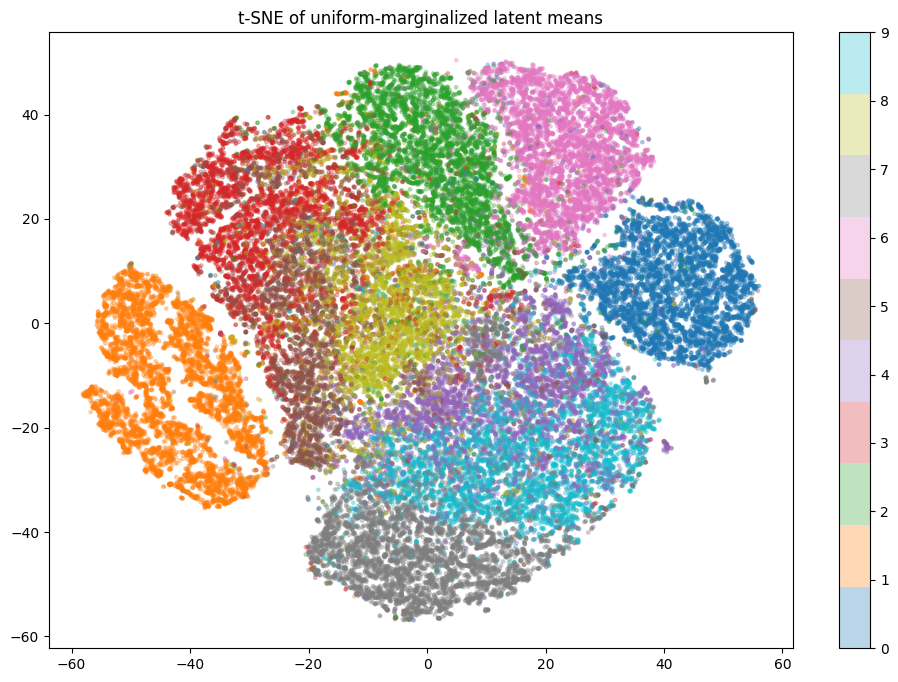

In [10]:
plt.figure(figsize=(12,8))
plt.scatter(z_2d[:,0], z_2d[:,1], c=all_labels, cmap='tab10', s=6, alpha=0.3)
plt.colorbar(ticks=range(10))
plt.title("t-SNE of uniform-marginalized latent means")
plt.savefig(fname="digits-distribution")
plt.show()

#### 2D Interpolation

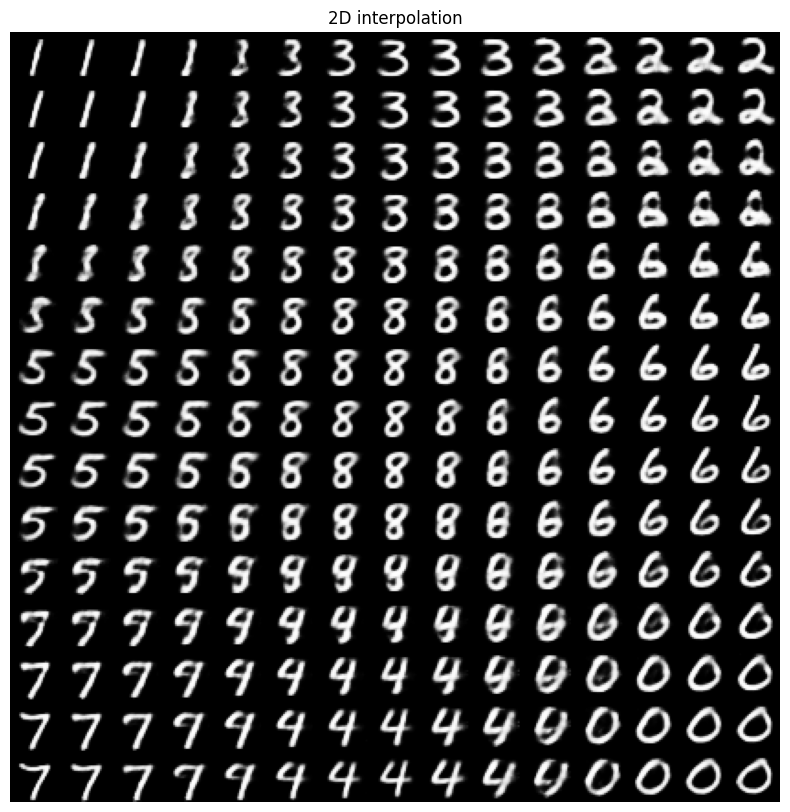

In [11]:
grid_size = 15
digits_3x3 = [
    [1, 3, 2],
    [5, 8, 6],
    [7, 4, 0]
]

z_means = {}
for row in digits_3x3:
    for d in row:
        if d not in z_means:
            z_means[d] = torch.tensor(all_mu_mix[all_labels == d].mean(axis=0), device=device, dtype=torch.float)

y_onehots = {d: F.one_hot(torch.tensor([d]), num_classes).float().to(device) for row in digits_3x3 for d in row}

# Bilinear interpolation
def interpolate(a, b, t):
    return a * (1 - t) + b * t

grid = np.zeros((28 * grid_size, 28 * grid_size))
for i, v in enumerate(np.linspace(0, 1, grid_size)):
    for j, u in enumerate(np.linspace(0, 1, grid_size)):
        # Determine which cell in the 3x3 grid we are in
        cell_x = int(u * 2)  # 0, 1, 2
        cell_y = int(v * 2)  # 0, 1, 2
        # local interpolation in the cell
        u_local = (u - cell_x / 2) * 2
        v_local = (v - cell_y / 2) * 2

        # Corners of the current cell
        z_tl = z_means[digits_3x3[cell_y][cell_x]]
        z_tr = z_means[digits_3x3[cell_y][min(cell_x + 1, 2)]]
        z_bl = z_means[digits_3x3[min(cell_y + 1, 2)][cell_x]]
        z_br = z_means[digits_3x3[min(cell_y + 1, 2)][min(cell_x + 1, 2)]]

        y_tl = y_onehots[digits_3x3[cell_y][cell_x]]
        y_tr = y_onehots[digits_3x3[cell_y][min(cell_x + 1, 2)]]
        y_bl = y_onehots[digits_3x3[min(cell_y + 1, 2)][cell_x]]
        y_br = y_onehots[digits_3x3[min(cell_y + 1, 2)][min(cell_x + 1, 2)]]

        # Bilinear interpolation
        z_top = interpolate(z_tl, z_tr, u_local)
        z_bottom = interpolate(z_bl, z_br, u_local)
        z_mix = interpolate(z_top, z_bottom, v_local).unsqueeze(0)

        y_top = interpolate(y_tl, y_tr, u_local)
        y_bottom = interpolate(y_bl, y_br, u_local)
        y_mix = interpolate(y_top, y_bottom, v_local)

        # Decode and fill grid
        x_decoded = model.decode(z_mix, y_mix).detach().cpu().numpy().reshape(28, 28)
        grid[i * 28:(i + 1) * 28, j * 28:(j + 1) * 28] = x_decoded

plt.figure(figsize=(10, 10))
plt.imshow(grid, cmap="gray")
plt.axis("off")
plt.title("2D interpolation")
plt.savefig(fname="2D-interpolation")
plt.show()

## Unlearning a class in CVAE

In [12]:
label_to_drop = 4
lambda_ewc = 100
gamma_contrast = 1
unlearn_iters = 10000
unlearn_batch_size = 256
unlearn_lr = 1e-4
unlearn_epochs = 10000

In [13]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model_clone = copy.deepcopy(model)
model_clone.eval()

CVAE(
  (fc1): Linear(in_features=794, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc_mu): Linear(in_features=256, out_features=8, bias=True)
  (fc_logvar): Linear(in_features=256, out_features=8, bias=True)
  (fc3): Linear(in_features=18, out_features=256, bias=True)
  (fc4): Linear(in_features=256, out_features=512, bias=True)
  (fc5): Linear(in_features=512, out_features=784, bias=True)
)

### Compute Fisher Matrix

In [ ]:
fisher_dict = {}
params_mle_dict = {}

for name, param in model.named_parameters():
    fisher_dict[name] = torch.zeros_like(param)
    params_mle_dict[name] = param.data.clone()

model.eval()
for _ in range(50000):
    with torch.no_grad():
        z = torch.randn(1, latent_dim, device=device)
        c = torch.randint(0 ,10, (1,)).to(device)
        c = F.one_hot(c, 10)
        model.eval()
        sample = model.decode(z, c)

    model.train()
    model.zero_grad()
    recon_x, mu, logvar = model(sample, c)
    loss = loss_function(recon_x, sample, mu, logvar)
    loss.backward()

    for name, param in model.named_parameters():
        fisher_dict[name] += param.grad.data.pow(2)

for name in fisher_dict:
    fisher_dict[name] /= 50000.0


save_path = "fisher_data.pth"
torch.save({
    "fisher_dict": fisher_dict,
    "params_mle_dict": params_mle_dict
}, save_path)
print(f"Saved Fisher information and MLE params to {save_path}")

In [14]:
checkpoint = torch.load("fisher_data.pth", map_location=device)
fisher_dict = checkpoint["fisher_dict"]
params_mle_dict = checkpoint["params_mle_dict"]

print("Loaded Fisher and MLE parameter data successfully.")

Loaded Fisher and MLE parameter data successfully.


/tmp/ipykernel_6576/4168566224.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load("fisher_data.pth", map_location=device)


### Training the model with unlearning
class 4 is selected to be unlearned

In [15]:
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

model.train()
label_choices = list(range(num_classes))
label_choices.remove(label_to_drop)

for step in range(unlearn_epochs):
    c_remember = torch.from_numpy(
        np.random.choice(label_choices, size=batch_size)
    ).to(device)
    y_remember = F.one_hot(c_remember, num_classes).float()
    z_remember = torch.randn(batch_size, latent_dim).to(device)

    with torch.no_grad():
        x_remember = model_clone.decode(z_remember, y_remember.to(device)).view(-1, 784)

    c_forget = torch.ones(batch_size, dtype=int) * label_to_drop
    y_forget = F.one_hot(c_forget, num_classes).float().to(device)
    x_forget = torch.rand(batch_size, 784).to(device)

    optimizer.zero_grad()

    recon_f, mu_f, logvar_f = model(x_forget, y_forget)
    loss_forget = loss_function(recon_f, x_forget, mu_f, logvar_f)

    recon_r, mu_r, logvar_r = model(x_remember, y_remember.to(device))
    loss_remember = loss_function(recon_r, x_remember, mu_r, logvar_r)

    loss = loss_forget + gamma_contrast * loss_remember

    ewc_penalty = 0
    for name, param in model.named_parameters():
        ewc_penalty += (fisher_dict[name] * (param - params_mle_dict[name]).pow(2)).sum()
    loss += lambda_ewc * ewc_penalty

    loss.backward()
    optimizer.step()

    if (step + 1) % 1000 == 0:
        print(f"[Unlearn Step {step+1}/{unlearn_epochs}] Loss: {loss.item():.4f}")

torch.save(model.state_dict(), "cvae_unlearned.pth")
print("Unlearning complete!")

[Unlearn Step 1000/10000] Loss: 170770.3594
[Unlearn Step 2000/10000] Loss: 169122.3906
[Unlearn Step 3000/10000] Loss: 168379.7812
[Unlearn Step 4000/10000] Loss: 168288.3438
[Unlearn Step 5000/10000] Loss: 168412.8125
[Unlearn Step 6000/10000] Loss: 167386.8906
[Unlearn Step 7000/10000] Loss: 167745.9844
[Unlearn Step 8000/10000] Loss: 168089.5469
[Unlearn Step 9000/10000] Loss: 167271.1562
[Unlearn Step 10000/10000] Loss: 167429.2500
Unlearning complete!


### Visualization

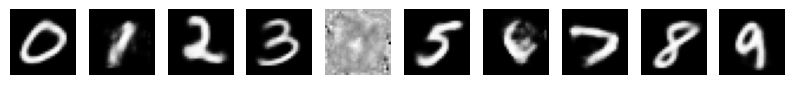

In [16]:
model.eval()
with torch.no_grad():
    # Generate one sample for each digit 0-9
    z = torch.randn(num_classes, latent_dim).to(device)
    labels = torch.arange(num_classes).to(device)
    y = F.one_hot(labels, num_classes).float()
    # y = F.one_hot(torch.full((10,), 4, device=labels.device), num_classes).float()
    samples = model.decode(z, y.to(device)).cpu().view(-1, 1, 28, 28)

    fig, axes = plt.subplots(1, num_classes, figsize=(10, 1))
    for i, ax in enumerate(axes):
        ax.imshow(samples[i, 0], cmap="gray")
        ax.axis("off")
    plt.show()

## Attack to Unlearned CVAE
Trying to train the unlearned model step by step (per each `epoch_interval` epochs) and apply the attacck to see the results

### Label Manipulation Attack

In [17]:
def label_manipulation(
    model,
    forgotten_label=4,
    remembered_label=9,
    num_points=8,
    num_classes=10,
    latent_dim=8,
):
    """
    Soft-label (label manipulation) attack.
    Matches return format of other attack functions.
    """

    model.eval()

    zs = torch.randn(num_points, latent_dim).to(device)

    alphas = torch.linspace(0, 1, num_points).to(device)
    y_f_onehot = F.one_hot(torch.tensor([forgotten_label]), num_classes).float().to(device)
    y_r_onehot = F.one_hot(torch.tensor([remembered_label]), num_classes).float().to(device)

    ys_soft = []
    for α in alphas:
        y = α * y_f_onehot + (1 - α) * y_r_onehot
        ys_soft.append(y)

    ys_soft = torch.cat(ys_soft, dim=0).view(num_points, num_classes).float().to(device)

    y_f_full = F.one_hot(
        torch.ones(num_points, dtype=int) * forgotten_label,
        num_classes
    ).float().to(device)

    y_r_full = F.one_hot(
        torch.ones(num_points, dtype=int) * remembered_label,
        num_classes
    ).float().to(device)

    with torch.no_grad():
        recon_soft = model.decode(zs, ys_soft).cpu()
        recon_forget = model.decode(zs, y_f_full).cpu()
        recon_remember = model.decode(zs, y_r_full).cpu()

    diff_soft_f = (recon_soft - recon_forget).abs().mean().item()
    diff_soft_r = (recon_soft - recon_remember).abs().mean().item()

    metrics = {
        "mean_distance_to_forgotten": diff_soft_f,
        "mean_distance_to_remembered": diff_soft_r,
        "alphas": alphas.cpu().numpy(),
    }

    return {
        "name": "label_manipulation",
        "metrics": metrics,
        "images": {
            "forget_seq": recon_forget[:4],
            "remember_seq": recon_remember[:4],
            "soft_seq": recon_soft[:8],
        }
    }


### Latent Interpolation Attack

In [18]:
def latent_interpolation(model):
    """
    Latent Interpolation Attack:
    - Fix two random latent vectors z1, z2.
    - Generate N interpolations between them.
    - Decode with forgotten-label conditioning.
    - Decode with remembered-label conditioning (control).
    - Return both sequences + simple leakage metrics.
    """
    model.eval()

    num_points = 10
    z_dim = latent_dim
    device = next(model.parameters()).device

    z1 = torch.randn(1, z_dim).to(device)
    z2 = torch.randn(1, z_dim).to(device)

    alphas = torch.linspace(0, 1, num_points).to(device)
    zs = torch.stack([(1 - a) * z1 + a * z2 for a in alphas], dim=0).squeeze(1)

    y_forget = F.one_hot(
        torch.ones(num_points, dtype=int) * label_to_drop,
        num_classes
    ).float().to(device)
    
    remembered_label = [i for i in range(num_classes) if i != label_to_drop][0]
    y_remember = F.one_hot(
        torch.ones(num_points, dtype=int) * remembered_label,
        num_classes
    ).float().to(device)
    
    with torch.no_grad():
        recon_f = model.decode(zs, y_forget).cpu()
        recon_r = model.decode(zs, y_remember).cpu()

    mean_diff = (recon_f - recon_r).abs().mean().item()
    var_diff  = (recon_f.var() - recon_r.var()).abs().item()

    metrics = {
        "mean_abs_difference": mean_diff,
        "variance_difference": var_diff,
    }

    return {
        "name": "latent_interpolation",
        "metrics": metrics,
        "images": {
            "forget_seq": recon_f[:4],
            "remember_seq": recon_r[:4],
        }
    }


### Visualization Tools

In [19]:
def show_attack_images(attack_result, max_images=4):
    if "images" not in attack_result or "forget_seq" not in attack_result["images"]:
        print("No images found for this attack.")
        return

    imgs = attack_result["images"]["forget_seq"][:max_images]

    n = len(imgs)
    plt.figure(figsize=(1.5*n, 2))
    for i, img in enumerate(imgs):
        plt.subplot(1, n, i+1)
        plt.imshow(img.reshape(28,28), cmap="gray")
        plt.axis("off")
        plt.title("Forgotten", fontsize=8)
    plt.tight_layout()
    plt.show()


In [20]:
def save_attack_summary(history, attack_name, outdir="attack_outputs"):
    os.makedirs(outdir, exist_ok=True)
    num_steps = len(history)
    imgs_per_step = history[0]["images"]["forget_seq"].shape[0]

    fig, axs = plt.subplots(
        num_steps,
        imgs_per_step,
        figsize=(imgs_per_step * 1.4, num_steps * 1.4)
    )

    if num_steps == 1:
        axs = axs[None, :]

    for row, step_data in enumerate(history):
        forget_imgs = step_data["images"]["forget_seq"]
        for col in range(imgs_per_step):
            ax = axs[row][col]
            img = forget_imgs[col].reshape(28, 28)
            ax.imshow(img, cmap="gray")
            ax.axis("off")
            if row == 0:
                ax.set_title(f"Img {col+1}", fontsize=7)

    plt.tight_layout()

    filename = f"{attack_name}_SUMMARY.png"
    filepath = os.path.join(outdir, filename)
    fig.savefig(filepath, dpi=150, bbox_inches="tight")
    plt.close(fig)

    print(f"[✓] Saved summary: {filepath}")


In [21]:
epoch_interval = 500
total_unlearn_steps = 10000
model = copy.deepcopy(original_model)
model_clone = copy.deepcopy(model)
model_clone.eval()

CVAE(
  (fc1): Linear(in_features=794, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc_mu): Linear(in_features=256, out_features=8, bias=True)
  (fc_logvar): Linear(in_features=256, out_features=8, bias=True)
  (fc3): Linear(in_features=18, out_features=256, bias=True)
  (fc4): Linear(in_features=256, out_features=512, bias=True)
  (fc5): Linear(in_features=512, out_features=784, bias=True)
)


=== Evaluating attacks at step 500 ===
Attack result: {'mean_distance_to_forgotten': 0.06657928973436356, 'mean_distance_to_remembered': 0.04401126131415367, 'alphas': array([0.        , 0.14285715, 0.2857143 , 0.42857146, 0.57142854,
       0.71428573, 0.85714287, 1.        ], dtype=float32)}


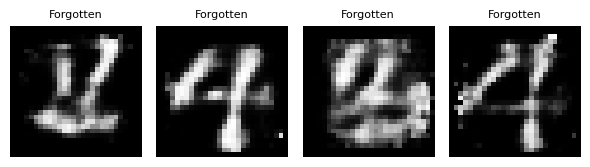


=== Evaluating attacks at step 1000 ===
Attack result: {'mean_distance_to_forgotten': 0.05634529888629913, 'mean_distance_to_remembered': 0.05478320270776749, 'alphas': array([0.        , 0.14285715, 0.2857143 , 0.42857146, 0.57142854,
       0.71428573, 0.85714287, 1.        ], dtype=float32)}


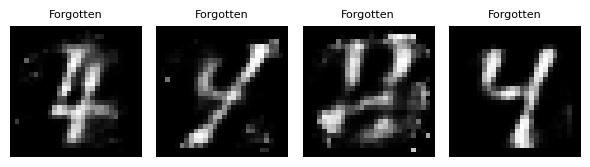


=== Evaluating attacks at step 1500 ===
Attack result: {'mean_distance_to_forgotten': 0.048303376883268356, 'mean_distance_to_remembered': 0.04166440665721893, 'alphas': array([0.        , 0.14285715, 0.2857143 , 0.42857146, 0.57142854,
       0.71428573, 0.85714287, 1.        ], dtype=float32)}


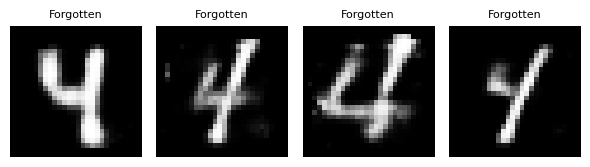


=== Evaluating attacks at step 2000 ===
Attack result: {'mean_distance_to_forgotten': 0.05364273488521576, 'mean_distance_to_remembered': 0.05223489925265312, 'alphas': array([0.        , 0.14285715, 0.2857143 , 0.42857146, 0.57142854,
       0.71428573, 0.85714287, 1.        ], dtype=float32)}


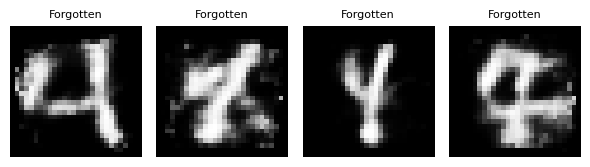


=== Evaluating attacks at step 2500 ===
Attack result: {'mean_distance_to_forgotten': 0.044627606868743896, 'mean_distance_to_remembered': 0.06751725822687149, 'alphas': array([0.        , 0.14285715, 0.2857143 , 0.42857146, 0.57142854,
       0.71428573, 0.85714287, 1.        ], dtype=float32)}


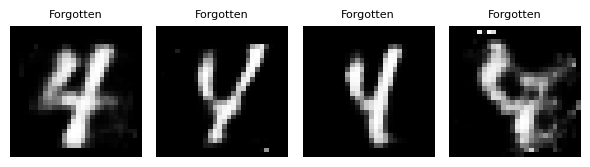


=== Evaluating attacks at step 3000 ===
Attack result: {'mean_distance_to_forgotten': 0.044066570699214935, 'mean_distance_to_remembered': 0.04801982641220093, 'alphas': array([0.        , 0.14285715, 0.2857143 , 0.42857146, 0.57142854,
       0.71428573, 0.85714287, 1.        ], dtype=float32)}


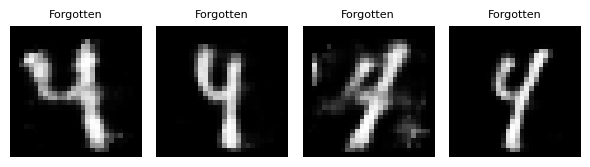


=== Evaluating attacks at step 3500 ===
Attack result: {'mean_distance_to_forgotten': 0.051370494067668915, 'mean_distance_to_remembered': 0.04113307222723961, 'alphas': array([0.        , 0.14285715, 0.2857143 , 0.42857146, 0.57142854,
       0.71428573, 0.85714287, 1.        ], dtype=float32)}


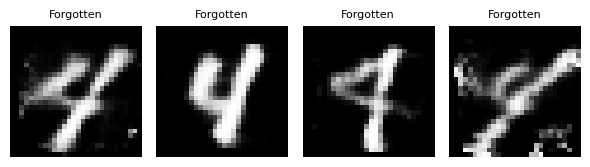


=== Evaluating attacks at step 4000 ===
Attack result: {'mean_distance_to_forgotten': 0.09267667680978775, 'mean_distance_to_remembered': 0.06188102811574936, 'alphas': array([0.        , 0.14285715, 0.2857143 , 0.42857146, 0.57142854,
       0.71428573, 0.85714287, 1.        ], dtype=float32)}


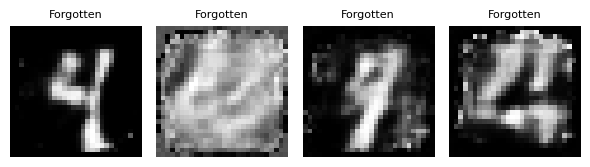


=== Evaluating attacks at step 4500 ===
Attack result: {'mean_distance_to_forgotten': 0.08531656861305237, 'mean_distance_to_remembered': 0.06874202936887741, 'alphas': array([0.        , 0.14285715, 0.2857143 , 0.42857146, 0.57142854,
       0.71428573, 0.85714287, 1.        ], dtype=float32)}


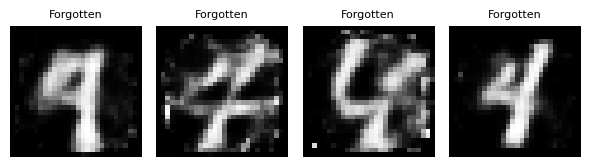


=== Evaluating attacks at step 5000 ===
Attack result: {'mean_distance_to_forgotten': 0.09128695726394653, 'mean_distance_to_remembered': 0.07802113890647888, 'alphas': array([0.        , 0.14285715, 0.2857143 , 0.42857146, 0.57142854,
       0.71428573, 0.85714287, 1.        ], dtype=float32)}


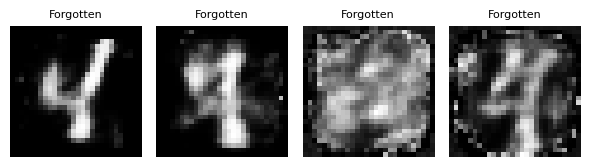


=== Evaluating attacks at step 5500 ===
Attack result: {'mean_distance_to_forgotten': 0.11887601017951965, 'mean_distance_to_remembered': 0.06900154054164886, 'alphas': array([0.        , 0.14285715, 0.2857143 , 0.42857146, 0.57142854,
       0.71428573, 0.85714287, 1.        ], dtype=float32)}


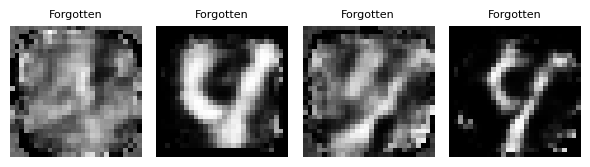


=== Evaluating attacks at step 6000 ===
Attack result: {'mean_distance_to_forgotten': 0.12648746371269226, 'mean_distance_to_remembered': 0.10842078179121017, 'alphas': array([0.        , 0.14285715, 0.2857143 , 0.42857146, 0.57142854,
       0.71428573, 0.85714287, 1.        ], dtype=float32)}


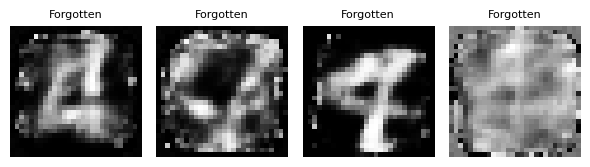


=== Evaluating attacks at step 6500 ===
Attack result: {'mean_distance_to_forgotten': 0.1496516317129135, 'mean_distance_to_remembered': 0.1337398886680603, 'alphas': array([0.        , 0.14285715, 0.2857143 , 0.42857146, 0.57142854,
       0.71428573, 0.85714287, 1.        ], dtype=float32)}


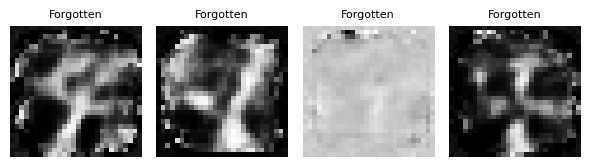


=== Evaluating attacks at step 7000 ===
Attack result: {'mean_distance_to_forgotten': 0.17403069138526917, 'mean_distance_to_remembered': 0.14277426898479462, 'alphas': array([0.        , 0.14285715, 0.2857143 , 0.42857146, 0.57142854,
       0.71428573, 0.85714287, 1.        ], dtype=float32)}


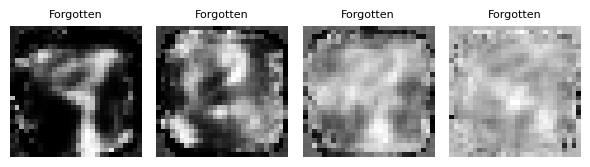


=== Evaluating attacks at step 7500 ===
Attack result: {'mean_distance_to_forgotten': 0.22979317605495453, 'mean_distance_to_remembered': 0.17691083252429962, 'alphas': array([0.        , 0.14285715, 0.2857143 , 0.42857146, 0.57142854,
       0.71428573, 0.85714287, 1.        ], dtype=float32)}


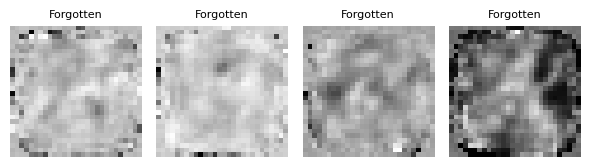


=== Evaluating attacks at step 8000 ===
Attack result: {'mean_distance_to_forgotten': 0.2307315617799759, 'mean_distance_to_remembered': 0.17737731337547302, 'alphas': array([0.        , 0.14285715, 0.2857143 , 0.42857146, 0.57142854,
       0.71428573, 0.85714287, 1.        ], dtype=float32)}


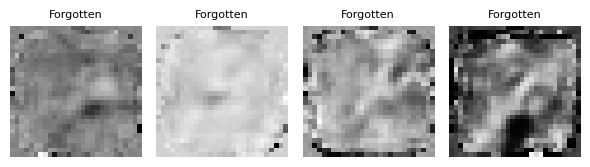


=== Evaluating attacks at step 8500 ===
Attack result: {'mean_distance_to_forgotten': 0.2084440439939499, 'mean_distance_to_remembered': 0.18461167812347412, 'alphas': array([0.        , 0.14285715, 0.2857143 , 0.42857146, 0.57142854,
       0.71428573, 0.85714287, 1.        ], dtype=float32)}


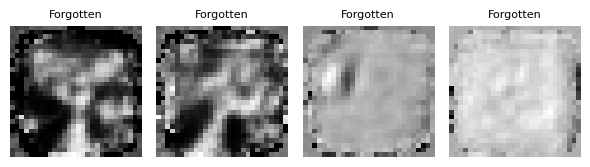


=== Evaluating attacks at step 9000 ===
Attack result: {'mean_distance_to_forgotten': 0.24901995062828064, 'mean_distance_to_remembered': 0.1826322078704834, 'alphas': array([0.        , 0.14285715, 0.2857143 , 0.42857146, 0.57142854,
       0.71428573, 0.85714287, 1.        ], dtype=float32)}


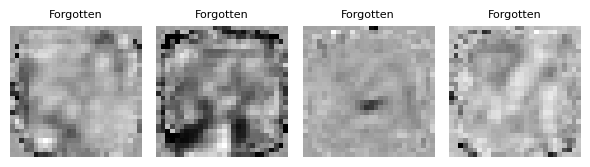


=== Evaluating attacks at step 9500 ===
Attack result: {'mean_distance_to_forgotten': 0.23771831393241882, 'mean_distance_to_remembered': 0.16490192711353302, 'alphas': array([0.        , 0.14285715, 0.2857143 , 0.42857146, 0.57142854,
       0.71428573, 0.85714287, 1.        ], dtype=float32)}


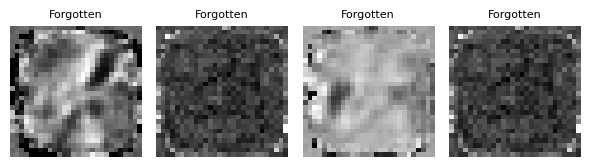


=== Evaluating attacks at step 10000 ===
Attack result: {'mean_distance_to_forgotten': 0.2318076491355896, 'mean_distance_to_remembered': 0.22514201700687408, 'alphas': array([0.        , 0.14285715, 0.2857143 , 0.42857146, 0.57142854,
       0.71428573, 0.85714287, 1.        ], dtype=float32)}


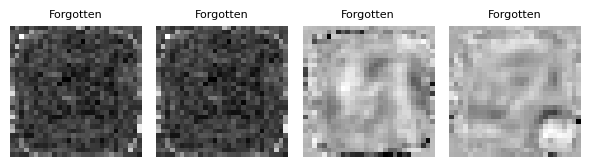


=== Unlearning and Applying Label Manipulation Completed ===
[✓] Saved summary: attack_outputs/label_manipulation_SUMMARY.png


In [22]:
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

label_choices = list(range(num_classes))
label_choices.remove(label_to_drop)

step = 0

attack_history = []
model.train()
while step < total_unlearn_steps:
    for _ in range(epoch_interval):
        c_remember = torch.from_numpy(
            np.random.choice(label_choices, size=batch_size)
        ).to(device)
        y_remember = F.one_hot(c_remember, num_classes).float()
        z_remember = torch.randn(batch_size, latent_dim).to(device)

        with torch.no_grad():
            x_remember = model_clone.decode(z_remember, y_remember).view(-1, 784)

        c_forget = torch.ones(batch_size, dtype=int) * label_to_drop
        y_forget = F.one_hot(c_forget, num_classes).float().to(device)
        x_forget = torch.rand(batch_size, 784).to(device)

        optimizer.zero_grad()

        recon_f, mu_f, logvar_f = model(x_forget, y_forget)
        loss_forget = loss_function(recon_f, x_forget, mu_f, logvar_f)

        recon_r, mu_r, logvar_r = model(x_remember, y_remember)
        loss_remember = loss_function(recon_r, x_remember, mu_r, logvar_r)

        ewc_penalty = 0.0
        for name, param in model.named_parameters():
            ewc_penalty += (fisher_dict[name] * (param - params_mle_dict[name]).pow(2)).sum()

        loss = loss_forget + gamma_contrast * loss_remember + lambda_ewc * ewc_penalty

        loss.backward()
        optimizer.step()

        step += 1

    print(f"\n=== Evaluating attacks at step {step} ===")
    attack_result = label_manipulation(model)

    print("Attack result:", attack_result["metrics"])

    attack_history.append(attack_result)

    if "images" in attack_result:
        show_attack_images(attack_result)

print("\n=== Unlearning and Applying Label Manipulation Completed ===")
save_attack_summary(attack_history, "label_manipulation")

In [23]:
epoch_interval = 500
total_unlearn_steps = 10000
model = copy.deepcopy(original_model)
model_clone = copy.deepcopy(model)
model_clone.eval()

CVAE(
  (fc1): Linear(in_features=794, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc_mu): Linear(in_features=256, out_features=8, bias=True)
  (fc_logvar): Linear(in_features=256, out_features=8, bias=True)
  (fc3): Linear(in_features=18, out_features=256, bias=True)
  (fc4): Linear(in_features=256, out_features=512, bias=True)
  (fc5): Linear(in_features=512, out_features=784, bias=True)
)


=== Evaluating attacks at step 500 ===
Attack result: {'mean_abs_difference': 0.21636205911636353, 'variance_difference': 0.007713012397289276}


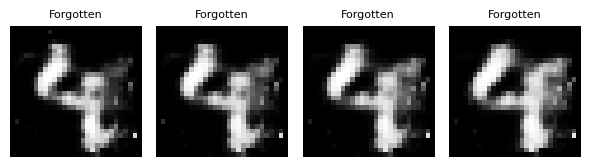


=== Evaluating attacks at step 1000 ===
Attack result: {'mean_abs_difference': 0.2070378214120865, 'variance_difference': 0.038078367710113525}


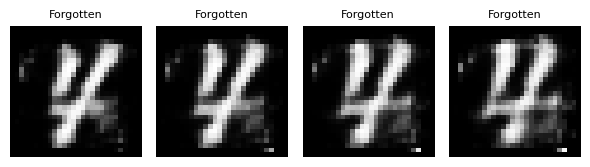


=== Evaluating attacks at step 1500 ===
Attack result: {'mean_abs_difference': 0.21924881637096405, 'variance_difference': 0.020510703325271606}


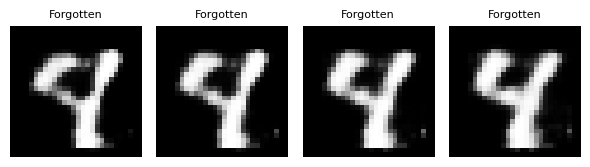


=== Evaluating attacks at step 2000 ===
Attack result: {'mean_abs_difference': 0.18609531223773956, 'variance_difference': 0.026689991354942322}


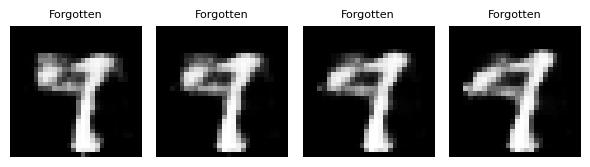


=== Evaluating attacks at step 2500 ===
Attack result: {'mean_abs_difference': 0.16343703866004944, 'variance_difference': 0.027690686285495758}


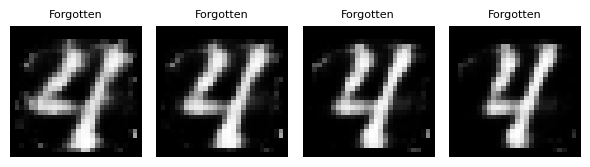


=== Evaluating attacks at step 3000 ===
Attack result: {'mean_abs_difference': 0.20354507863521576, 'variance_difference': 0.026158683001995087}


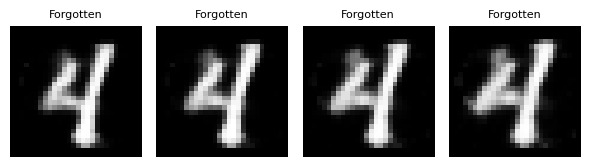


=== Evaluating attacks at step 3500 ===
Attack result: {'mean_abs_difference': 0.23829230666160583, 'variance_difference': 0.020220763981342316}


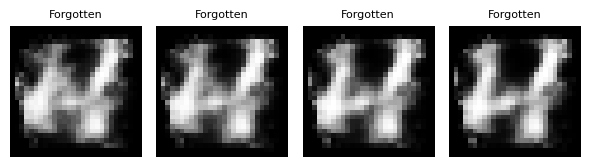


=== Evaluating attacks at step 4000 ===
Attack result: {'mean_abs_difference': 0.23223385214805603, 'variance_difference': 0.04743754863739014}


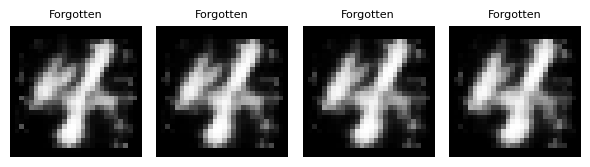


=== Evaluating attacks at step 4500 ===
Attack result: {'mean_abs_difference': 0.19387191534042358, 'variance_difference': 0.03162584453821182}


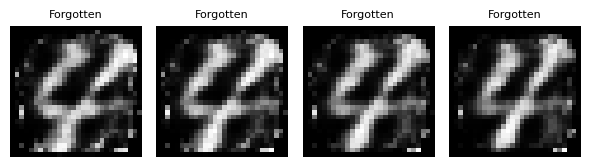


=== Evaluating attacks at step 5000 ===
Attack result: {'mean_abs_difference': 0.2729343771934509, 'variance_difference': 0.05952107161283493}


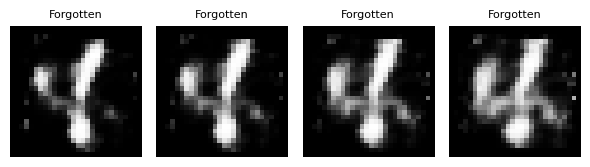


=== Evaluating attacks at step 5500 ===
Attack result: {'mean_abs_difference': 0.24022135138511658, 'variance_difference': 0.01831689476966858}


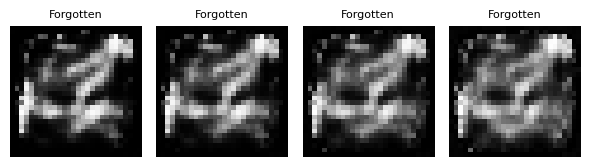


=== Evaluating attacks at step 6000 ===
Attack result: {'mean_abs_difference': 0.32529351115226746, 'variance_difference': 0.03410172462463379}


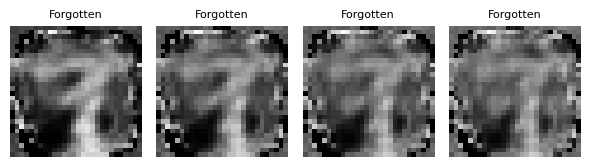


=== Evaluating attacks at step 6500 ===
Attack result: {'mean_abs_difference': 0.3976576030254364, 'variance_difference': 0.07701157033443451}


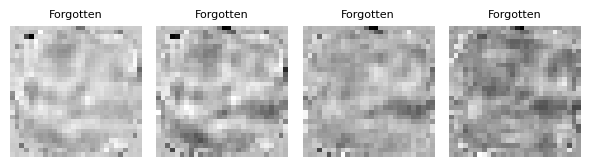


=== Evaluating attacks at step 7000 ===
Attack result: {'mean_abs_difference': 0.39336833357810974, 'variance_difference': 0.10792535543441772}


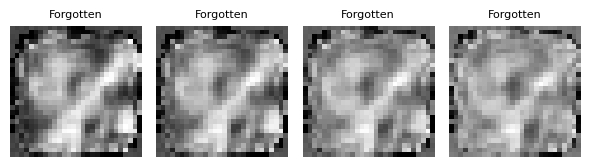


=== Evaluating attacks at step 7500 ===
Attack result: {'mean_abs_difference': 0.2187972068786621, 'variance_difference': 0.01971529796719551}


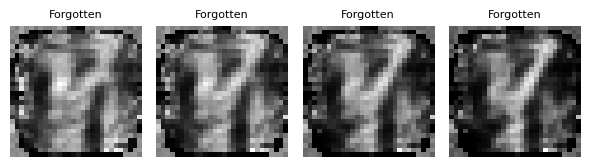


=== Evaluating attacks at step 8000 ===
Attack result: {'mean_abs_difference': 0.3471761643886566, 'variance_difference': 0.08183687180280685}


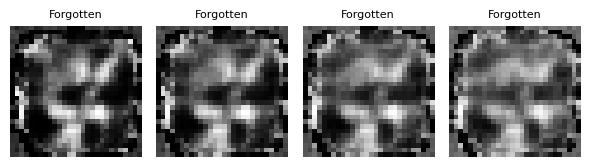


=== Evaluating attacks at step 8500 ===
Attack result: {'mean_abs_difference': 0.4449065029621124, 'variance_difference': 0.13105767965316772}


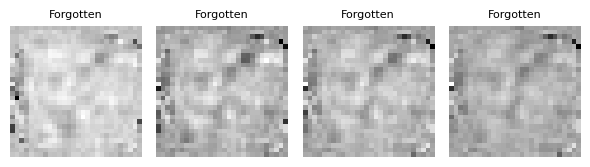


=== Evaluating attacks at step 9000 ===
Attack result: {'mean_abs_difference': 0.44681304693222046, 'variance_difference': 0.09837719798088074}


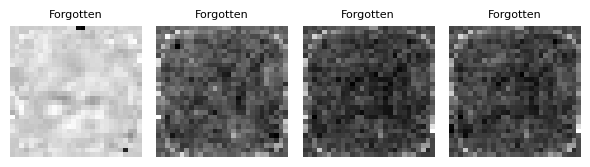


=== Evaluating attacks at step 9500 ===
Attack result: {'mean_abs_difference': 0.4429154396057129, 'variance_difference': 0.10331076383590698}


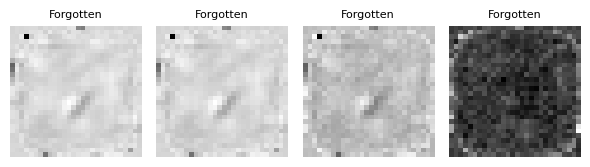


=== Evaluating attacks at step 10000 ===
Attack result: {'mean_abs_difference': 0.3719104826450348, 'variance_difference': 0.07135550677776337}


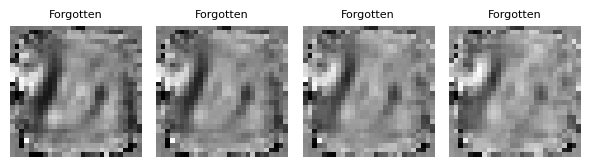


=== Unlearning and Applying Latent Interpolation Completed ===
[✓] Saved summary: attack_outputs/latent_interpolation_SUMMARY.png


In [24]:
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

label_choices = list(range(num_classes))
label_choices.remove(label_to_drop)

step = 0

attack_history = []
model.train()
while step < total_unlearn_steps:
    for _ in range(epoch_interval):
        c_remember = torch.from_numpy(
            np.random.choice(label_choices, size=batch_size)
        ).to(device)
        y_remember = F.one_hot(c_remember, num_classes).float()
        z_remember = torch.randn(batch_size, latent_dim).to(device)

        with torch.no_grad():
            x_remember = model_clone.decode(z_remember, y_remember).view(-1, 784)

        c_forget = torch.ones(batch_size, dtype=int) * label_to_drop
        y_forget = F.one_hot(c_forget, num_classes).float().to(device)
        x_forget = torch.rand(batch_size, 784).to(device)

        optimizer.zero_grad()

        recon_f, mu_f, logvar_f = model(x_forget, y_forget)
        loss_forget = loss_function(recon_f, x_forget, mu_f, logvar_f)

        recon_r, mu_r, logvar_r = model(x_remember, y_remember)
        loss_remember = loss_function(recon_r, x_remember, mu_r, logvar_r)

        ewc_penalty = 0.0
        for name, param in model.named_parameters():
            ewc_penalty += (fisher_dict[name] * (param - params_mle_dict[name]).pow(2)).sum()

        loss = loss_forget + gamma_contrast * loss_remember + lambda_ewc * ewc_penalty

        loss.backward()
        optimizer.step()

        step += 1

    print(f"\n=== Evaluating attacks at step {step} ===")
    attack_result = latent_interpolation(model)

    print("Attack result:", attack_result["metrics"])

    attack_history.append(attack_result)

    if "images" in attack_result:
        show_attack_images(attack_result)

print("\n=== Unlearning and Applying Latent Interpolation Completed ===")
save_attack_summary(attack_history, "latent_interpolation")

### Condition Optimization Attack

In [25]:
class MNISTClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.fc1 = nn.Linear(9216, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        return self.fc2(x)


In [26]:
classifier = MNISTClassifier().cuda()
opt = torch.optim.Adam(classifier.parameters(), lr=1e-3)

for epoch in range(3):
    for x, y in train_loader:
        x, y = x.cuda(), y.cuda()
        opt.zero_grad()
        logits = classifier(x)
        loss = F.cross_entropy(logits, y)
        loss.backward()
        opt.step()

print("Classifier trained.")

Classifier trained.


In [29]:
fixed_z = torch.randn(1, latent_dim).to(device)

def condition_optimization(model, classifier, target_class,
                           steps=3000, lr=0.02):
    model.eval()
    classifier.eval()

    z = fixed_z.clone()
    y = torch.randn(1, num_classes, device=device, requires_grad=True)

    optimizer = torch.optim.Adam([z, y], lr=lr)

    images = []

    for step in range(steps):
        optimizer.zero_grad()

        y_norm = y.softmax(dim=-1)

        x = model.decode(z, y_norm)

        x_in = x.view(-1, 1, 28, 28)

        logits = classifier(x_in)
        prob = torch.softmax(logits, dim=-1)[0, target_class]

        loss = -prob
        loss.backward()
        optimizer.step()

        if step % 750 == 0:
            images.append(x.detach().cpu()[0].view(28, 28))

    return {
        "name": "condition_optimization",
        "metrics": {"final_prob": float(prob.detach().cpu())},
        "images": {"forget_seq": torch.stack(images, dim=0)}
    }


In [30]:
epoch_interval = 500
total_unlearn_steps = 10000
model = copy.deepcopy(original_model)
model_clone = copy.deepcopy(model)
model_clone.eval()

CVAE(
  (fc1): Linear(in_features=794, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc_mu): Linear(in_features=256, out_features=8, bias=True)
  (fc_logvar): Linear(in_features=256, out_features=8, bias=True)
  (fc3): Linear(in_features=18, out_features=256, bias=True)
  (fc4): Linear(in_features=256, out_features=512, bias=True)
  (fc5): Linear(in_features=512, out_features=784, bias=True)
)


=== Evaluating attacks at step 500 ===
Attack result: {'final_prob': 0.9997143149375916}


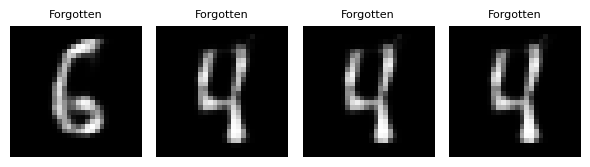


=== Evaluating attacks at step 1000 ===
Attack result: {'final_prob': 0.9996880292892456}


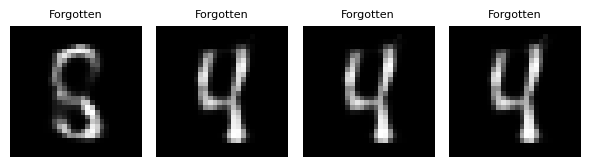


=== Evaluating attacks at step 1500 ===
Attack result: {'final_prob': 0.9996387958526611}


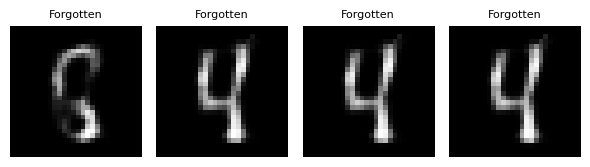


=== Evaluating attacks at step 2000 ===
Attack result: {'final_prob': 0.9997119307518005}


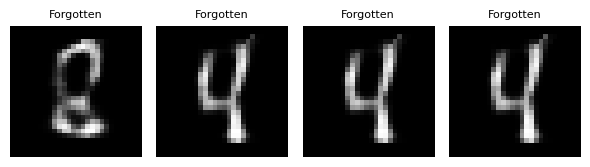


=== Evaluating attacks at step 2500 ===
Attack result: {'final_prob': 0.9998862743377686}


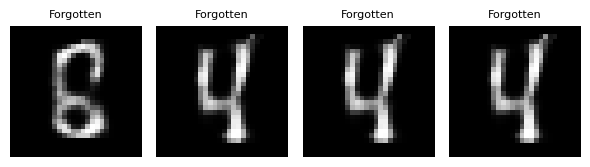


=== Evaluating attacks at step 3000 ===
Attack result: {'final_prob': 0.9998376369476318}


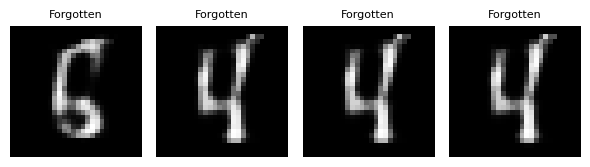


=== Evaluating attacks at step 3500 ===
Attack result: {'final_prob': 0.9998905658721924}


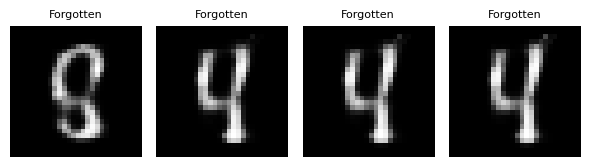


=== Evaluating attacks at step 4000 ===
Attack result: {'final_prob': 0.999896764755249}


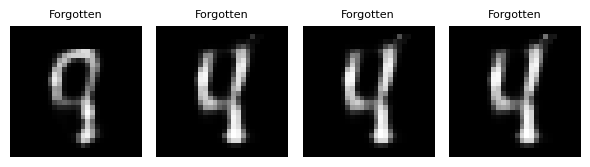


=== Evaluating attacks at step 4500 ===
Attack result: {'final_prob': 0.9998631477355957}


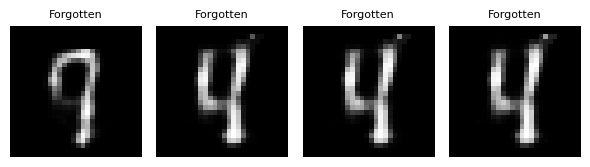


=== Evaluating attacks at step 5000 ===
Attack result: {'final_prob': 0.9998674392700195}


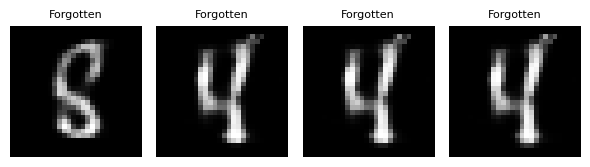


=== Evaluating attacks at step 5500 ===
Attack result: {'final_prob': 0.9997420907020569}


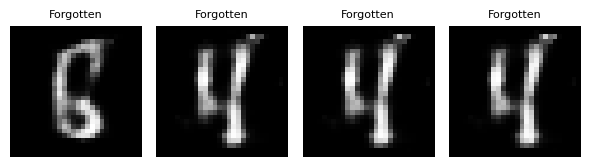


=== Evaluating attacks at step 6000 ===
Attack result: {'final_prob': 0.9997126460075378}


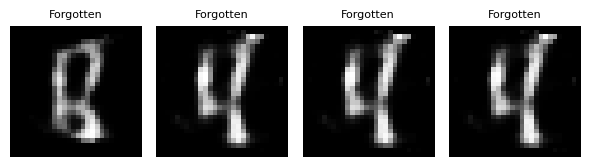


=== Evaluating attacks at step 6500 ===
Attack result: {'final_prob': 0.9995369911193848}


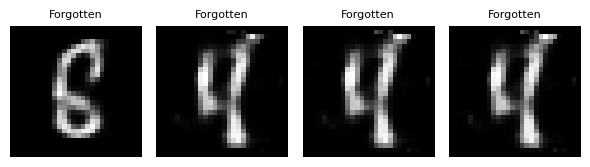


=== Evaluating attacks at step 7000 ===
Attack result: {'final_prob': 0.9987362027168274}


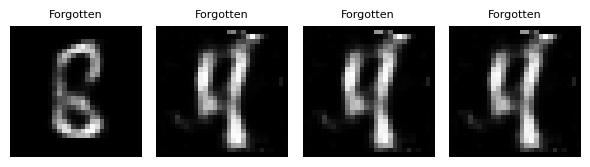


=== Evaluating attacks at step 7500 ===
Attack result: {'final_prob': 0.996903121471405}


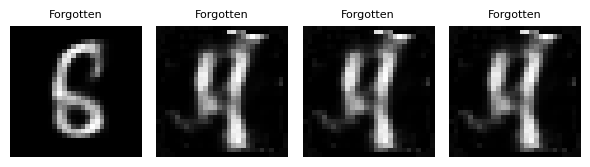


=== Evaluating attacks at step 8000 ===
Attack result: {'final_prob': 0.9802250266075134}


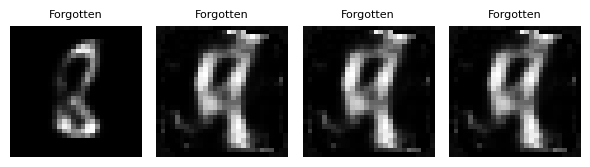


=== Evaluating attacks at step 8500 ===
Attack result: {'final_prob': 0.00023561438138131052}


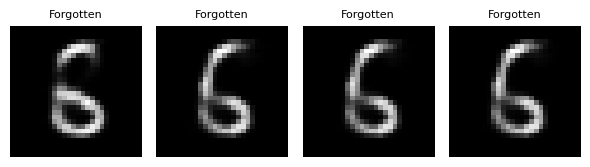


=== Evaluating attacks at step 9000 ===
Attack result: {'final_prob': 0.9513548016548157}


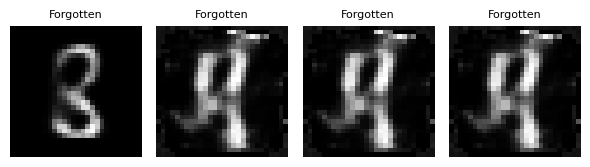


=== Evaluating attacks at step 9500 ===
Attack result: {'final_prob': 0.973787784576416}


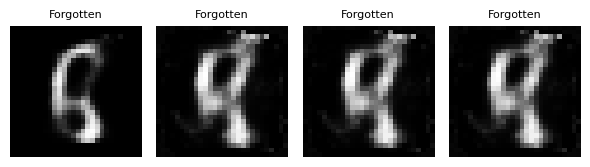


=== Evaluating attacks at step 10000 ===
Attack result: {'final_prob': 0.9638209342956543}


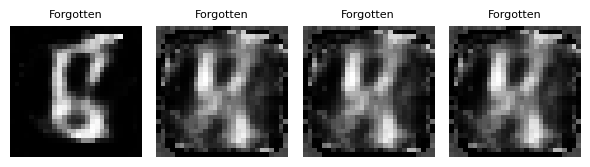


=== Unlearning and Applying Condition Optimization Completed ===
[✓] Saved summary: attack_outputs/condition_optimization_SUMMARY.png


In [31]:
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

label_choices = list(range(num_classes))
label_choices.remove(label_to_drop)

step = 0

attack_history = []
model.train()
while step < total_unlearn_steps:
    for _ in range(epoch_interval):
        c_remember = torch.from_numpy(
            np.random.choice(label_choices, size=batch_size)
        ).to(device)
        y_remember = F.one_hot(c_remember, num_classes).float()
        z_remember = torch.randn(batch_size, latent_dim).to(device)

        with torch.no_grad():
            x_remember = model_clone.decode(z_remember, y_remember).view(-1, 784)

        c_forget = torch.ones(batch_size, dtype=int) * label_to_drop
        y_forget = F.one_hot(c_forget, num_classes).float().to(device)
        x_forget = torch.rand(batch_size, 784).to(device)

        optimizer.zero_grad()

        recon_f, mu_f, logvar_f = model(x_forget, y_forget)
        loss_forget = loss_function(recon_f, x_forget, mu_f, logvar_f)

        recon_r, mu_r, logvar_r = model(x_remember, y_remember)
        loss_remember = loss_function(recon_r, x_remember, mu_r, logvar_r)

        ewc_penalty = 0.0
        for name, param in model.named_parameters():
            ewc_penalty += (fisher_dict[name] * (param - params_mle_dict[name]).pow(2)).sum()

        loss = loss_forget + gamma_contrast * loss_remember + lambda_ewc * ewc_penalty

        loss.backward()
        optimizer.step()

        step += 1

    print(f"\n=== Evaluating attacks at step {step} ===")
    attack_result = condition_optimization(model, classifier, 4)

    print("Attack result:", attack_result["metrics"])

    attack_history.append(attack_result)

    if "images" in attack_result:
        show_attack_images(attack_result)

print("\n=== Unlearning and Applying Condition Optimization Completed ===")
save_attack_summary(attack_history, "condition_optimization")